In [2]:
# stretching the cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# cuda settings
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
mnist = input_data.read_data_sets("../data/mnist")

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


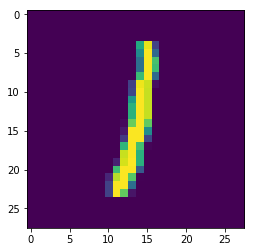

In [6]:
plt.imshow(mnist.train.images[4].reshape(28,28))

In [7]:
# wil take a random noise (z) and return the reconstructed image
def GN(z,reuse=None):
    
    with tf.variable_scope('gen',reuse=reuse):
        layer1 = tf.layers.dense(z,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,512,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,784,activation=tf.nn.tanh)

        return output
    

In [8]:
# will take an image x and will predict whether that belongs
# to data sample or random sample
def DN(X,reuse=None):
    
    with tf.variable_scope('dis',reuse=reuse):
        layer1 = tf.layers.dense(X,256,activation=tf.nn.relu)
        layer2 = tf.layers.dense(layer1,128,activation=tf.nn.relu)
        output = tf.layers.dense(layer2,1)

        return output

In [9]:
with tf.name_scope('placeholders'):
    real_image = tf.placeholder(tf.float32,shape=(None,784))
    z = tf.placeholder(tf.float32,shape=(None,100))

In [10]:
with tf.name_scope('logits'):
    fake_image = GN(z)

    real_logit = DN(real_image)
    fake_logit = DN(fake_image,reuse=True)

In [11]:
with tf.name_scope('losses'):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit,labels=tf.ones_like(real_logit)*0.9))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.zeros_like(fake_logit)))
    
    dloss = real_loss+fake_loss
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logit,labels=tf.ones_like(fake_logit)*0.9))
    

In [ ]:
# alternate loss function as described by ian goodfellow
# dloss = -tf.reduce_mean(tf.log(real_logit_prob)+tf.log(1. - fake_logit_prob))
# gloss = -tf.reduce_mean(tf.log(fake_logit_prob))

In [12]:
with tf.name_scope('varaibles'):
    allvars = tf.trainable_variables()
    dvars = [var for var in allvars if 'dis' in var.name]
    gvars = [var for var in allvars if 'gen' in var.name]

In [13]:
with tf.variable_scope('optimizer',reuse=tf.AUTO_REUSE):
    
    doptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(dloss,var_list=dvars)
    goptimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(gloss,var_list=gvars)

In [17]:
batch_size = 100
epoch = 3
new_generated_images=[]    

In [18]:
# training
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for epoch in range(epoch):
        
        for i in range(mnist.train.num_examples//batch_size):
        # for i in range(1):
            
            batch_data = mnist.train.next_batch(batch_size=batch_size)
            ximage = batch_data[0].reshape((batch_size,784))
            xsample = np.random.uniform(-1.,1.,size=(batch_size,100))
            sess.run(doptimizer,feed_dict={real_image:ximage,z:xsample})
            sess.run(goptimizer,feed_dict={z:xsample})
            if(i%500==0 and epoch%10==0):
                l1 = sess.run(dloss,feed_dict={real_image:ximage,z:xsample})
                l2 = sess.run(gloss,feed_dict={z:xsample})
                print("after {} losses : Descriptor : {} Generator : {}\n".format(i,l1,l2))
        
        print("On epoch {}".format(epoch))
        cur_sample = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(fake_image,feed_dict={z:cur_sample})
        new_generated_images.append(gen_sample)
    # saver.save(sess,"./gan/mnist_gan_500.ckpt")

after 0 losses : Descriptor : 1.3803374767303467 Generator : 0.6730253100395203

after 500 losses : Descriptor : 0.6671879291534424 Generator : 1.5988162755966187

On epoch 0
On epoch 1
On epoch 2


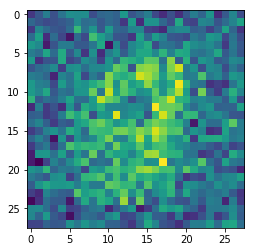

In [22]:
plt.imshow(new_generated_images[2].reshape(28,28))

# previously generated images

In [ ]:
len(generated_images)

In [ ]:
# previously generated images conditioned on 1
plt.figure()
plt.subplot(3,3,1)
plt.imshow(generated_images[32].reshape(28,28))
plt.subplot(3,3,2)
plt.imshow(generated_images[83].reshape(28,28))
plt.subplot(3,3,3)
plt.imshow(generated_images[283].reshape(28,28))
plt.subplot(3,3,4)
plt.imshow(generated_images[399].reshape(28,28))
plt.subplot(3,3,5)
plt.imshow(generated_images[400].reshape(28,28))
plt.subplot(3,3,6)
plt.imshow(generated_images[650].reshape(28,28))
plt.subplot(3,3,7)
plt.imshow(generated_images[769].reshape(28,28))
plt.subplot(3,3,8)
plt.imshow(generated_images[888].reshape(28,28))
plt.subplot(3,3,9)
plt.imshow(generated_images[999].reshape(28,28))